Import of necessary classes (extracted from FEDOT core):

In [8]:
import os
import random

import numpy as np
from sklearn.metrics import roc_auc_score as roc_auc

from gp_comp.example.classes.chain import Chain
from gp_comp.example.classes.model import *
from gp_comp.example.classes.node import NodeGenerator
from gp_comp.example.classes.utils import project_root
from gp_comp.example.classes.visualisation import ChainVisualiser

Fix random seed (to obtain reproducibility) and create a function for ROC AUC metric calculation.
ROC AUC is used as a classification quality metric because the scoring task usually deals with unbalanced sample:

In [2]:
random.seed(1)
np.random.seed(1)

def calculate_validation_metric(chain: Chain, dataset_to_validate: InputData) -> float:
    # the execution of the obtained composite models
    predicted = chain.predict(dataset_to_validate)
    # the quality assessment for the simulation results
    roc_auc_value = roc_auc(y_true=dataset_to_v alidate.target,
                            y_score=predicted.predict)
    return roc_auc_value

The dataset was obtained from https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring.
    
The variables are the following: 

* **SeriousDlqin2yrs** - Person experienced 90 days past due delinquency or worse (Target variable / label)

* **RevolvingUtilizationOfUnsecuredLines** - Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

* **age** - Age of borrower in years

* **NumberOfTime30-59DaysPastDueNotWorse** - Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

* **DebtRatio** - Monthly debt payments, alimony,living costs divided by monthy gross income

* **MonthlyIncome** -  Monthly income

* **NumberOfOpenCreditLinesAndLoans** - Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

* **NumberOfTimes90DaysLate** - Number of times borrower has been 90 days or more past due.

* **NumberRealEstateLoansOrLines** - Number of mortgage and real estate loans including home equity lines of credit

* **NumberOfTime60-89DaysPastDueNotWorse** - Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

* **NumberOfDependents** - Number of dependents in family excluding themselves (spouse, children etc.)

The data are stored in the CSV format:

In [3]:
# a dataset that will be used as a train and test set during composition
file_path_train = 'data\scoring_train.csv'
full_path_train = os.path.join(str(project_root()), file_path_train)
dataset_to_train = InputData.from_csv(full_path_train)

# a dataset for a final validation of the composed model
file_path_test = 'data\scoring_test.csv'
full_path_test = os.path.join(str(project_root()), file_path_test)
dataset_to_validate = InputData.from_csv(full_path_test)

Create new chain with selected nodes (XGBoost, multi-layer perceptron, linear discriminant analysis, K-nearest and decision tree models are used):

In [13]:
complex_chain = Chain()

last_node = NodeGenerator.secondary_node(MLP())

y1 = NodeGenerator.primary_node(XGBoost(), dataset_to_train)
complex_chain.add_node(y1)

y2 = NodeGenerator.primary_node(LDA(), dataset_to_train)
complex_chain.add_node(y2)

y3 = NodeGenerator.secondary_node(RandomForest(), [y1, y2])
complex_chain.add_node(y3)

y4 = NodeGenerator.primary_node(KNN(), dataset_to_train)
complex_chain.add_node(y4)
y5 = NodeGenerator.primary_node(DecisionTree(), dataset_to_train)
complex_chain.add_node(y5)

y6 = NodeGenerator.secondary_node(QDA(), [y4, y5])
complex_chain.add_node(y6)

last_node.nodes_from = [y3, y6]
complex_chain.add_node(last_node)

In [14]:
simple_chain = Chain()
y1 = NodeGenerator.primary_node(XGBoost(), dataset_to_train)
simple_chain.add_node(y1)

Visualise chain and calculate metrics:

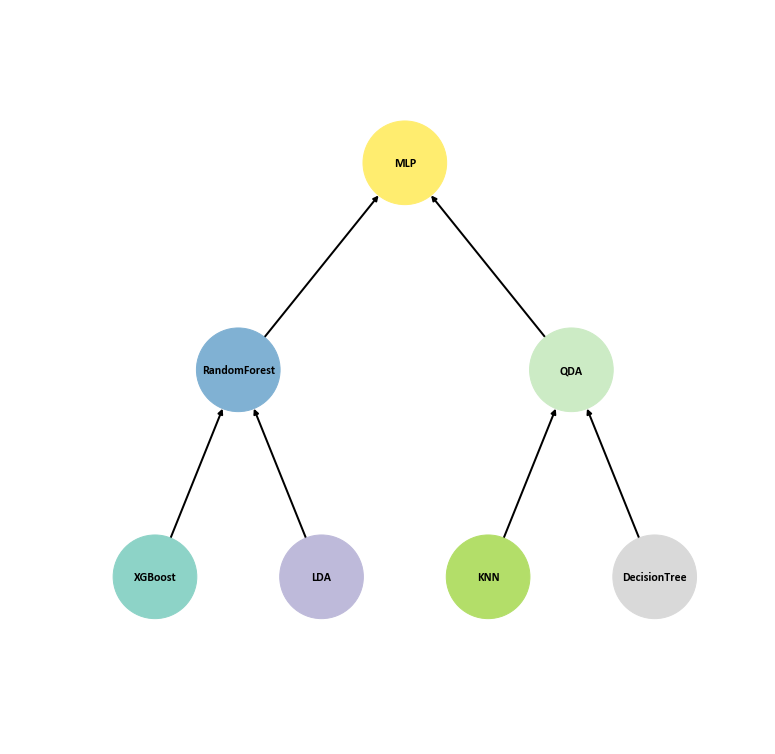

ROC AUC for complex chain is 0.882
ROC AUC for single model is 0.863


In [16]:
import warnings
warnings.filterwarnings("ignore")


visualiser = ChainVisualiser()
visualiser.visualise(complex_chain)

# the quality assessment for the obtained models
roc_on_complex_chain = calculate_validation_metric(complex_chain, dataset_to_validate)
roc_on_simple_chain = calculate_validation_metric(simple_chain, dataset_to_validate)

print(f'ROC AUC for complex chain is {round(roc_on_complex_chain, 3)}')
print(f'ROC AUC for single model is {round(roc_on_simple_chain, 3)}')

It can be seen that quality of the obtained complex multi-model chain is better.